# Fashion mnist notebook

* The fashion mnist data consists of 70,000 images divided into 60,000 training and 10,000 testing samples. Dataset sample consists of 28x28 grayscale image, associated with a label from 10 classes that represents the article of clothing . This is a multiclass classification problem.


* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.


* In this notebook we will try to predict which label the images belongs to. (The labels will comes next), by using dimensionality reduction (there are 784 dimensions) and more.

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

### Import the data

In [6]:
df_train=pd.read_csv("C:/Users/97254/.conda/fashion-mnist_train.csv")
df_test=pd.read_csv("C:/Users/97254/.conda/fashion-mnist_test.csv")

In [7]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_train.shape

(60000, 785)

#### There are 785 columns, each columm is one pixel, so there are 784 pixels as we said (the 'label' column is our target )

### Labels

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

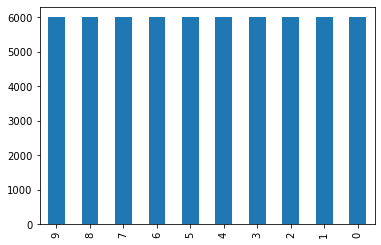

In [46]:
df_train.label.value_counts().plot(kind='bar')

* So there are 10 labels, and 60000 samples. each one of the labels has 6000 samples. 

In [87]:
y = df_train['label'] #target
x = df_train.drop(['label'], axis=1).to_numpy() #data
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42)

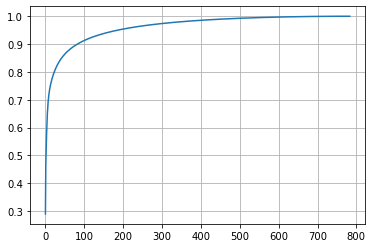

In [88]:
pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)


In [92]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_train, y_train)

    image = rnd_clf.feature_importances_.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")



cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()    

NameError: name 'mpl' is not defined

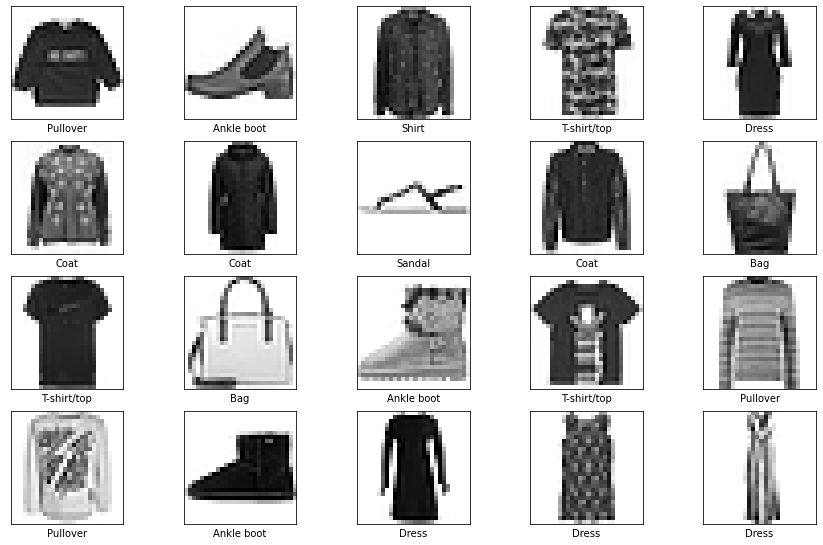

In [70]:
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target = df_train[['label']].iloc[:, :]
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(df_train.drop(['label'],axis=1).iloc[i, :]).reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(label[target.label.iloc[i]])

In [129]:
pca= PCA(n_components=25)
X_train_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, y, test_size=0.2, random_state=0)


In [127]:
def result(model):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(round(metrics.accuracy_score(y_test,y_predict)*100,4),"%")

In [130]:
rfc=RandomForestClassifier()
result(rfc)

86.0917 %


In [124]:
knn = KNeighborsClassifier(n_neighbors=7)
result(knn)

85.175 %
